# Set up Enviroment

In [22]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import numpy as np

In [23]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.5.1 anndata==0.7.3 umap==0.4.4 numpy==1.19.0 scipy==1.5.0 pandas==1.0.5 scikit-learn==0.23.1 statsmodels==0.11.1 python-igraph==0.8.2 louvain==0.7.0


# Load Data

In [24]:
# loading in count data
DM_count = ['DM_count_data']
data_dir_1 = '/data/DM1/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_1,var_names='gene_symbols',cache=True))
DM_count[1].var_names_make_unique(join='_')

data_dir_2 = '/data/DM2/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_2,var_names='gene_symbols',cache=True))
DM_count[2].var_names_make_unique(join='_')

data_dir_3 = '/data/DM3/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_3,var_names='gene_symbols',cache=True))
DM_count[3].var_names_make_unique(join='_')

data_dir_4 = '/data/DM4/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_4,var_names='gene_symbols',cache=True))
DM_count[4].var_names_make_unique(join='_')

data_dir_5 = '/data/DM5/outs/filtered_feature_bc_matrix'
DM_count.append(sc.read_10x_mtx(data_dir_5,var_names='gene_symbols',cache=True))
DM_count[5].var_names_make_unique(join='_')

for i in range(1,6):
    DM_count[i].obs['sample'] = 'DM'+str(i)

DM_count[1].obs['user_group'] = 'MJ'
DM_count[2].obs['user_group'] = 'NONE'
DM_count[3].obs['user_group'] = 'MJ'
DM_count[4].obs['user_group'] = 'COC'
DM_count[5].obs['user_group'] = 'DUAL'

# merging all the count objects into one object
combined = DM_count[1].concatenate(DM_count[i] for i in range(2,6))
combined

... reading from cache file cache/data-DM1-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM2-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM3-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM4-outs-filtered_feature_bc_matrix-matrix.h5ad
... reading from cache file cache/data-DM5-outs-filtered_feature_bc_matrix-matrix.h5ad


AnnData object with n_obs × n_vars = 19155 × 33538
    obs: 'sample', 'user_group', 'batch'
    var: 'gene_ids', 'feature_types'

# QC Metrics

Compute and examine basic QC metrics before filtering

In [4]:
sc.pp.calculate_qc_metrics(combined, inplace=True)

In [5]:
# Check the computed metric names
# log1p: log(X+1) transform
combined

AnnData object with n_obs × n_vars = 19155 × 33538
    obs: 'sample', 'user_group', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes'
    var: 'gene_ids', 'feature_types', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

Next compute metrics for mitochondrial genes and ribosomal genes

In [6]:
# Mitochondrial genes
mito_genes = combined.var_names.str.startswith('MT-')
# for each cell compute fraction of counts in mito genes vs. all genes
# the `.A1` is only necessary as X is sparse (to transform to a dense array after summing)
combined.obs['percent_mito'] = np.sum(combined[:, mito_genes].X, axis=1).A1 / np.sum(combined.X, axis=1).A1
# add the total counts per cell as observations-annotation to adata
combined.obs['n_counts'] = combined.X.sum(axis=1).A1

In [7]:
sum(mito_genes)

13

In [8]:
# Ribosomal genes
ribo_genes = combined.var_names.str.startswith(("RPS","RPL"))
combined.obs['percent_ribo'] = np.sum(combined[:, ribo_genes].X, axis=1).A1 / np.sum(combined.X, axis=1).A1

print(sum(ribo_genes))

104


... storing 'sample' as categorical
... storing 'user_group' as categorical
... storing 'feature_types' as categorical


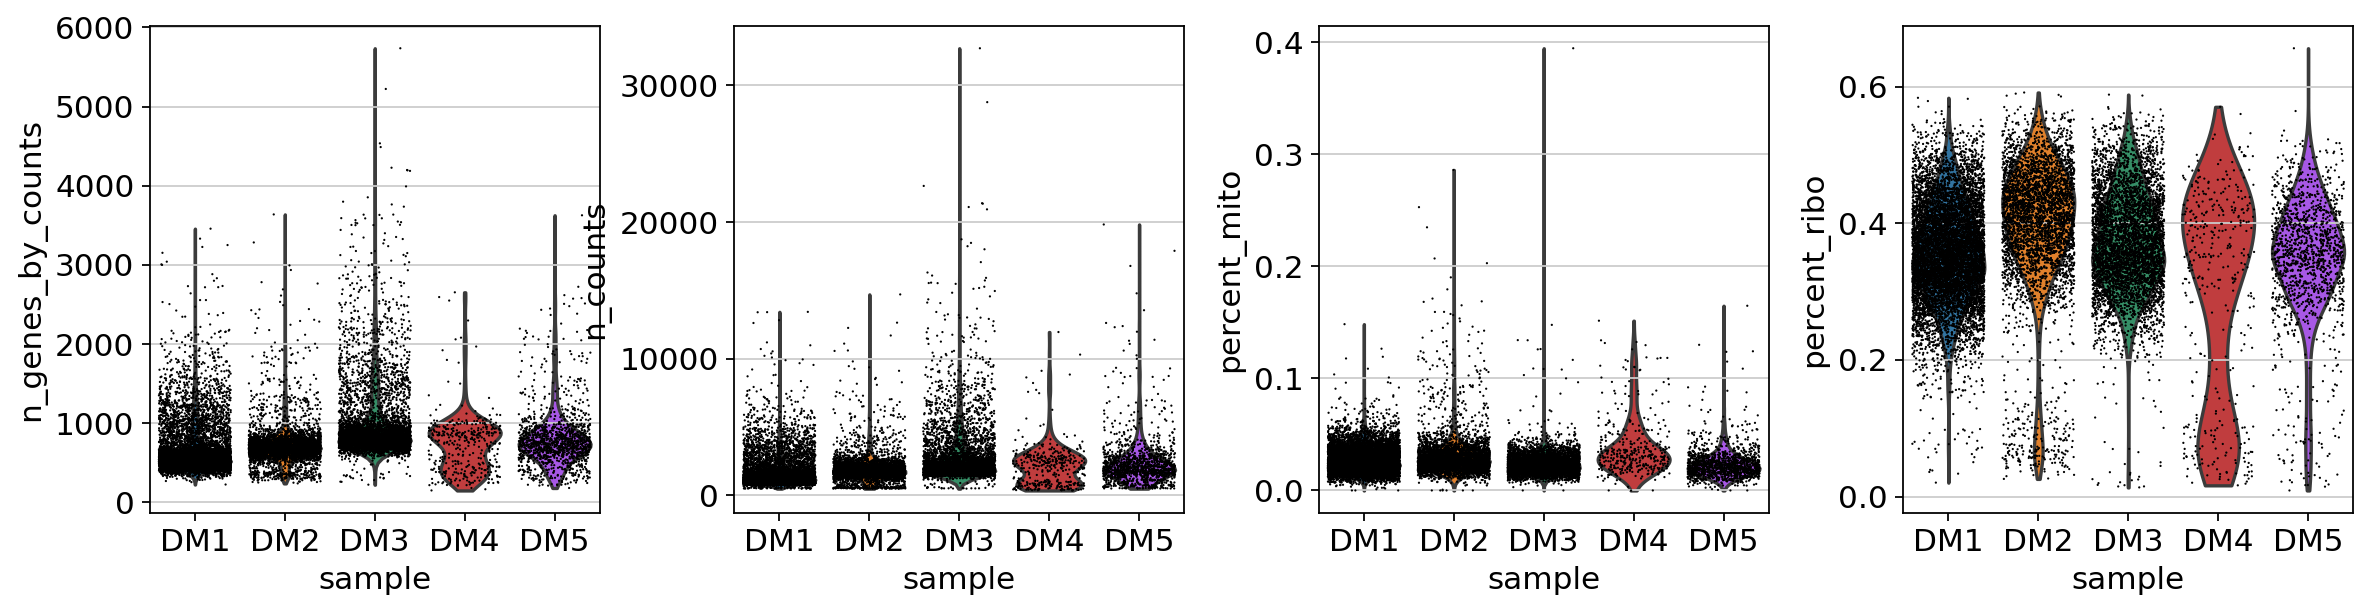

In [9]:
# Plotting QC metrics
# n_counts: total number of reads per cell
# n_genes_by_counts: the number mapped genes 
# percent_mito: percent of mitochondrial reads in total number of reads
# percent_ribo: percent of ribosomal reads in total number of reads
sc.pl.violin(combined, ['n_genes_by_counts','n_counts','percent_mito','percent_ribo'], jitter=0.4, groupby='sample')

In [10]:
print("The number of cells and genes before filtering: {},{}".format(combined.n_obs, combined.n_vars))

The number of cells and genes before filtering: 19155,33538


# QC Filter

## Preliminary Filtering

Filtering out genes expressed in less than 3 cells (not useful for statistical analysis due to effect of random error) and cells that have less than 200 expressed genes (broken cells for sure). 

In [11]:
sc.pp.filter_cells(combined, min_genes=200)
sc.pp.filter_genes(combined, min_cells=3)
print("The number of cells and genes left: {},{}".format(combined.n_obs, combined.n_vars))

filtered out 4 cells that have less than 200 genes expressed
filtered out 15369 genes that are detected in less than 3 cells
The number of cells and genes left: 19151,18169


## Cell Filtering Based on QC Violin Plots

We then filter out the cells that have too many genes detected (doublet). Based on the above violin plt for n_genes_by_counts, the thresholds for DM1-DM5 should be  1100, 1400, 1600, 1600, 1500 (basically twice the average which can be eyeballed around the belly of the violin) respectively. Also there is a double belly for DM4 and fat tails for DM2,DM5 (most likely due to dead cells) and we should also set a new min_genes=300 for them respectively. 

In [12]:
# filter for DM1
keep_DM1 = (combined.obs['n_genes_by_counts'] < 1100) & (combined.obs['sample'] == 'DM1')
print("Cells left in DM1: "+str(sum(keep_DM1)))
# filter for DM2
keep_DM2 = (combined.obs['n_genes_by_counts'] < 1400) & (combined.obs['n_genes_by_counts'] >300) &(combined.obs['sample'] == 'DM2')
print("Cells left in DM2: "+str(sum(keep_DM2)))
# filter for DM3
keep_DM3 = (combined.obs['n_genes_by_counts'] < 1600) & (combined.obs['sample'] == 'DM3')
print("Cells left in DM3: "+str(sum(keep_DM3)))
# filter for DM4
keep_DM4 = (combined.obs['n_genes_by_counts'] < 1600) & (combined.obs['n_genes_by_counts'] >300) &(combined.obs['sample'] == 'DM4')
print("Cells left in DM4: "+str(sum(keep_DM4)))
# filter for DM4
keep_DM5 = (combined.obs['n_genes_by_counts'] < 1500) & (combined.obs['n_genes_by_counts'] >300) &(combined.obs['sample'] == 'DM5')
print("Cells left in DM2: "+str(sum(keep_DM5)))

Cells left in DM1: 7916
Cells left in DM2: 3706
Cells left in DM3: 4424
Cells left in DM4: 341
Cells left in DM2: 1263


Combine the kept cells again

In [13]:
keep = (keep_DM1) | (keep_DM2) | (keep_DM3)| (keep_DM4)| (keep_DM5)
combined = combined[keep, :]

print("Total remaining cells %d"%combined.n_obs)

Total remaining cells 17650


Filtering out cells with too high mitochondrial percentage or too low ribosomal genes percentage

In [14]:
# filter for high percent mito
combined = combined[combined.obs['percent_mito'] < 0.06, :]

# filter for high percent ribo > 0.05
combined = combined[combined.obs['percent_ribo'] > 0.15, :]

print("Total remaining cells %d"%combined.n_obs)

Total remaining cells 17173


Plot filtered QC

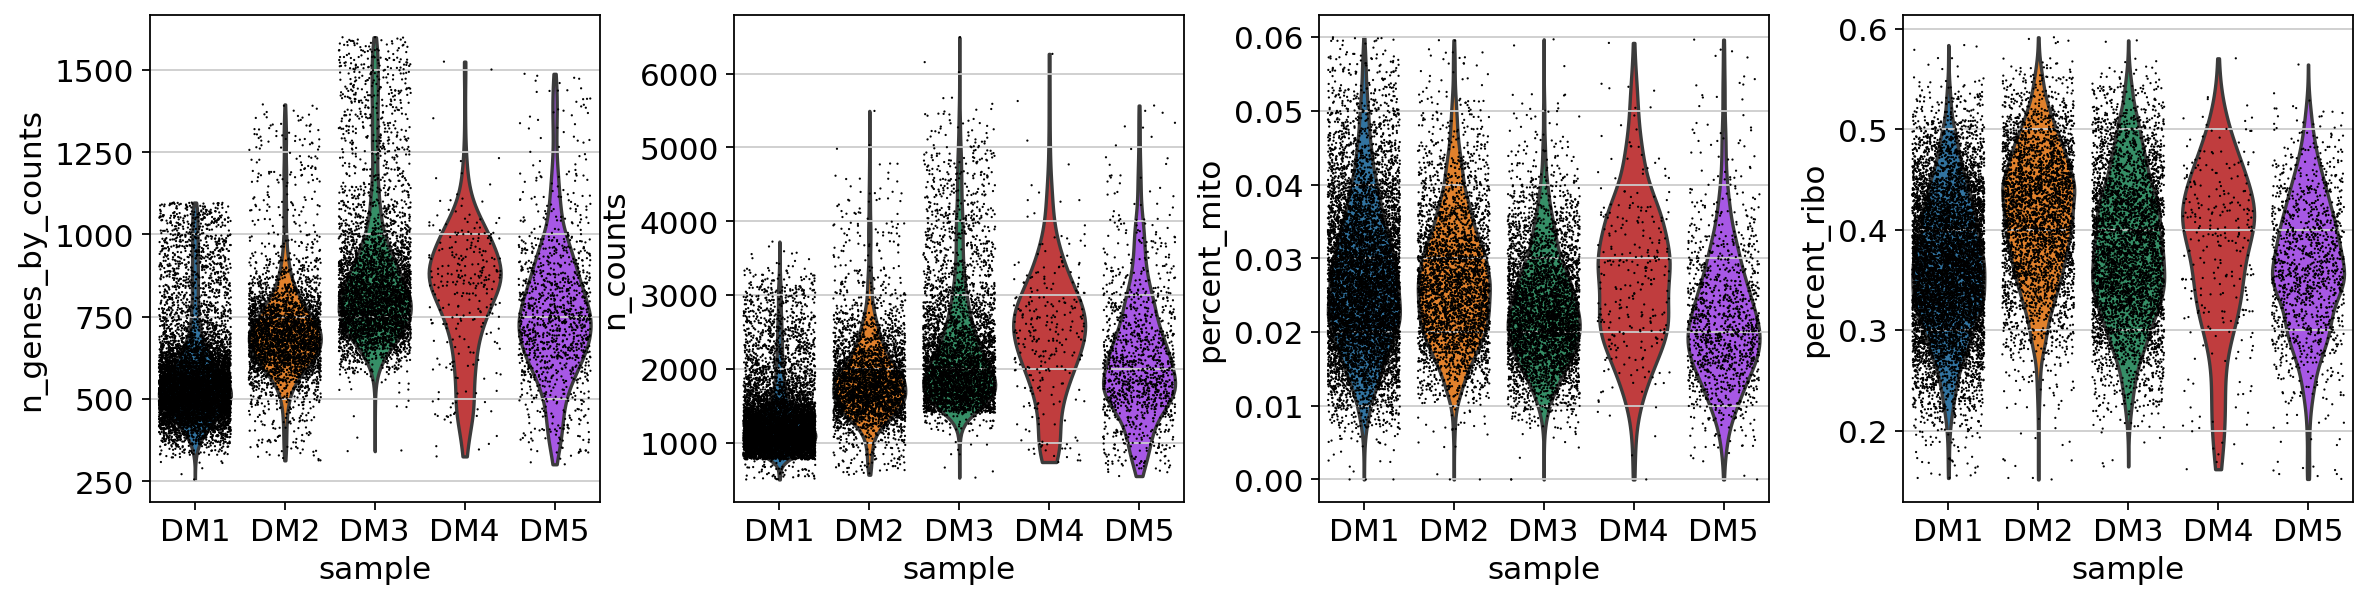

In [15]:
sc.pl.violin(combined, ['n_genes_by_counts', 'n_counts', 'percent_mito','percent_ribo'],jitter=0.4, groupby = 'sample')

## Gene Filtering 

First take a look at the gene expression levels

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


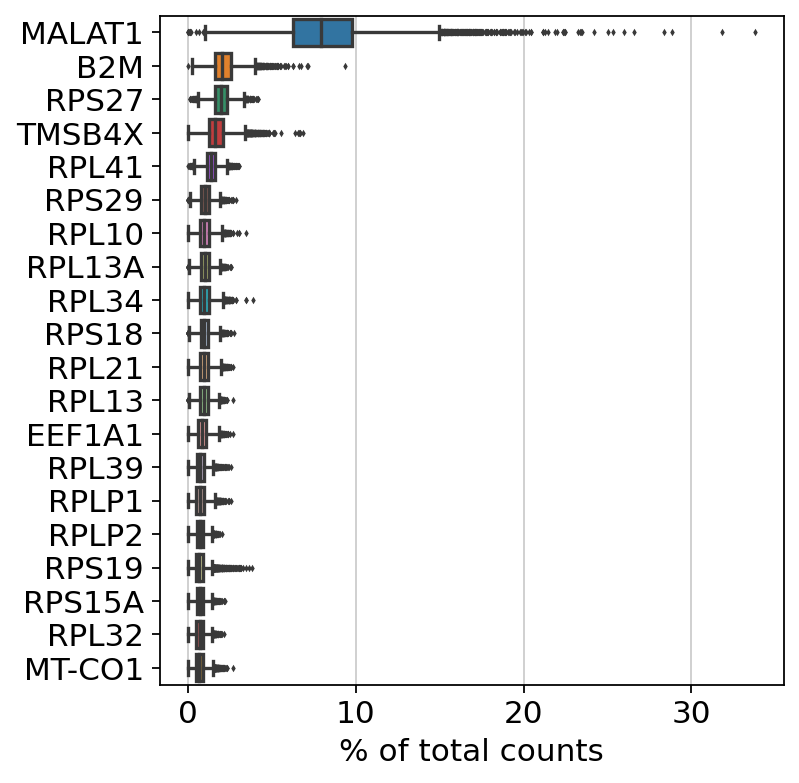

In [16]:
sc.pl.highest_expr_genes(combined, n_top=20)

As the level of expression of MALAT1 genes are much much higher (which goes up to 34%) than that of the rest genes, we need to remove them from the dataset to before we encounter technical issues in further steps. We also remove mitochondrial genes which can also affect downstream analysis results. 

In [20]:
malat1 = combined.var_names.str.startswith('MALAT1')
mitos = combined.var_names.str.startswith('MT-')
remove = np.add(malat1,mitos)


keep = np.invert(remove)
combined = combined[:,keep]

print("The number of cells and genes left: {},{}".format(combined.n_obs, combined.n_vars))

The number of cells and genes left: 17173,18053


Now look at the gene expression levels again

normalizing counts per cell
    finished (0:00:00)


/usr/local/lib/python3.6/dist-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


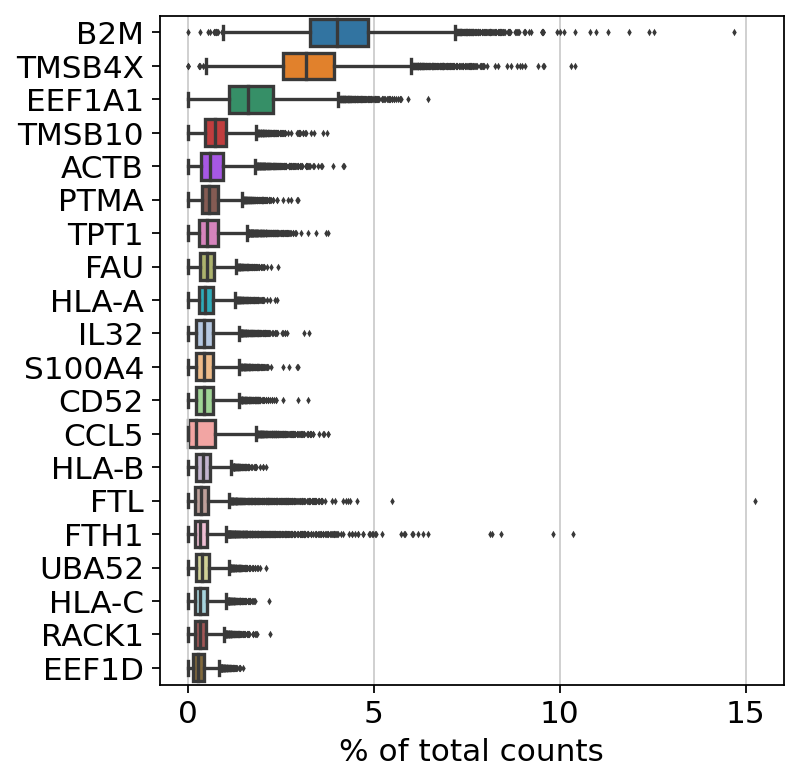

In [21]:
sc.pl.highest_expr_genes(combined, n_top=20)

In [19]:
save_file = '/scratch/qc_filtered_combined_samples.h5ad'
combined.write_h5ad(save_file)